# USING K-MEANS TO GROUP LIGAND BINDING SITES IN CLUSTERS BASED ON THEIR RSA PROFILE

## IMPORTING NECESSARY PACKAGES

In [1]:
from fragsys_analysis import *

## READING INPUT DATA

In [2]:
main_dir = "/Users/2394007/Documents/PHD/LOCAL/FRAGSYS_DEF/"
figs_dir = os.path.join(main_dir, "figs")
results_dir = os.path.join(main_dir, "results")

all_bs_ress = pd.read_csv(os.path.join(results_dir, "all_binding_site_residues_wgroup.csv"))
all_bss = pd.read_csv(os.path.join(results_dir, "all_binding_sites.csv"))
all_dssp_dfs = pd.read_csv(os.path.join(results_dir, "all_dssp_dfs.csv"))

all_bss_rsa = all_bss
all_bs_ress = all_bs_ress.drop_duplicates(["protein", "UniProt_ResNum", "UniProt_ResName"])

In [3]:
all_bss.head(3)

,bs_id,vars,occ,vars_per_occ,MES,p,norm_shenkin_rel,shenkin_ci,MES_ci,number_bs_res,number_ligs,prop_ligs,protein,group
0,BS0,95,392,0.242347,-0.363191,0.001768,26.629520,8.420723,0.230458,27,11,0.647059,Q9UGL1,0
1,BS1,40,119,0.336134,-0.014680,1.000000,34.049403,12.258819,0.362071,12,3,0.176471,Q9UGL1,0
2,BS2,42,134,0.313433,-0.086286,0.662416,31.261470,14.487844,0.350589,10,1,0.058824,Q9UGL1,0


In [4]:
cc = ["protein", "group", "BS0", "structure", "AA", "SS", "alignment_column", "UniProt_ResName", "UniProt_ResNum", "RSA", "abs_norm_shenkin", "log_oddsratio", "pvalue"] # most informatve columns

In [5]:
round(all_bs_ress, 2)[cc].head(3)

,protein,group,BS0,structure,AA,SS,alignment_column,UniProt_ResName,UniProt_ResNum,RSA,abs_norm_shenkin,log_oddsratio,pvalue
0,Q9UGL1,0,1,5fyy,V,C,228,V,99,31.69,41.53,-1.01,0.28
1,Q9UGL1,0,1,5fyy,Y,E,315,Y,425,18.02,6.01,-0.18,1.00
2,Q9UGL1,0,1,5fyy,A,E,317,A,427,7.55,14.81,-0.87,0.39


## GETTING RSA DISTRIBUTIONS

In [6]:
rsa_profs = get_rsa_profiles(all_bss_rsa, all_bs_ress)

0 res at BS7 of group 0 of O15178
0 res at BS15 of group 2 of P0DTD1


In [7]:
for k in list(rsa_profs.keys())[:5]:
    print(k, rsa_profs[k])

Q9UGL1_0_BS0 [0.0, 0.0, 0.8, 1.6, 2.0, 2.2, 3.6, 5.4, 6.3, 7.0, 7.4, 7.5, 9.2, 11.5, 12.0, 12.4, 15.2, 18.0, 18.5, 19.0, 19.8, 22.8, 26.2, 31.7, 33.8, 50.7, 54.9]
Q9UGL1_0_BS1 [1.1, 2.1, 2.4, 3.0, 8.8, 12.6, 20.6, 27.3, 31.0, 42.7, 55.2, 57.2]
Q9UGL1_0_BS2 [0.4, 1.4, 4.1, 14.0, 27.6, 29.8, 34.8, 37.6, 47.1, 49.0]
Q9UGL1_0_BS3 [2.1, 2.8, 2.9, 22.1, 26.6, 34.6, 53.7, 86.6]
Q9UGL1_0_BS4 [4.4, 8.5, 21.3, 49.5, 56.7, 56.8]


### FILTERING DISTRIBUTIONS ACCORDING TO SITE SIZE

In [8]:
rsa_profs_filt = {k: v for k, v in rsa_profs.items() if len(v) > 0} # filtering out binding sites with a profile shorter than 0 (NONE)
rsa_profs_filt_lens = {k: len(v) for k, v in rsa_profs_filt.items()}
max_len = max(rsa_profs_filt_lens.values())
max_len # maximum RSA profile length, i.e., maximum binding site size

38

In [9]:
rsa_profs_filt_hmap = {k: sorted(v) for k, v in rsa_profs_filt.items()} # this is needed later for the representation of the LBS RSA-based clusters
for k, v in rsa_profs_filt_hmap.items():
    len_v = len(v)
    none_list = [None] * (max_len - len(v))
    v.extend(none_list)

In [10]:
len(rsa_profs_filt)

291

## GETTING UD MATRIX

In [11]:
UD_df = get_UD_matrix(rsa_profs_filt)

In [12]:
labs = UD_df.index.tolist()

In [13]:
UD_df.loc[labs[:5], labs[:5]]

,Q9UGL1_0_BS0,Q9UGL1_0_BS1,Q9UGL1_0_BS2,Q9UGL1_0_BS3,Q9UGL1_0_BS4
Q9UGL1_0_BS0,0.000000,0.197531,0.288889,0.287037,0.469136
Q9UGL1_0_BS1,0.197531,0.000000,0.083333,0.093750,0.305556
Q9UGL1_0_BS2,0.288889,0.083333,0.000000,0.000000,0.333333
Q9UGL1_0_BS3,0.287037,0.093750,0.000000,0.000000,0.208333
Q9UGL1_0_BS4,0.469136,0.305556,0.333333,0.208333,0.000000


In [40]:
UD_df.to_pickle(os.path.join(results_dir, "UD_df.pkl"))

## IDENTIFYING OPTIMAL K

### ELBOW ANALYSIS

In [14]:
Sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters = k, random_state = 0, n_init = 10)
    km = km.fit(UD_df)
    Sum_of_squared_distances.append(km.inertia_)

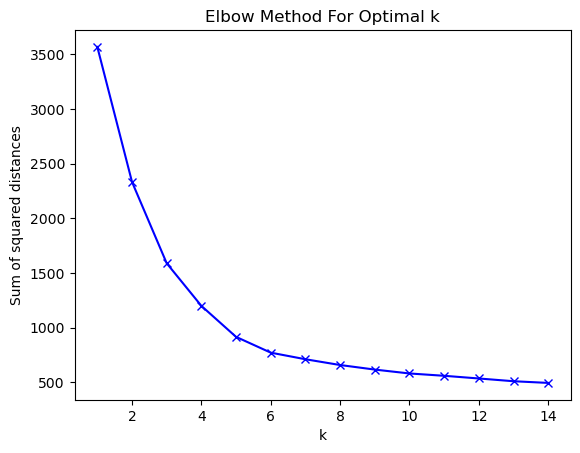

In [15]:
plt.plot(K, Sum_of_squared_distances, "bx-")
plt.xlabel("k")
plt.ylabel("Sum of squared distances")
plt.title("Elbow Method For Optimal k")
plt.show()

### SILHOUETTE ANALYSIS

In [16]:
silhouette_avg = []
range_n_clusters = list(range(2,15))
for k in range_n_clusters:

    #initialise kmeans
    km = KMeans(n_clusters = k, random_state = 0, n_init = 10)
    km = km.fit(UD_df)
    cluster_labels = km.labels_

     # silhouette score
    silhouette_avg.append(sklearn.metrics.silhouette_score(UD_df, cluster_labels))

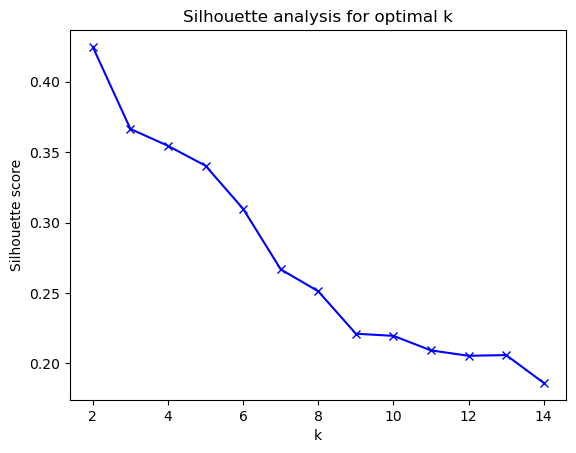

In [17]:
plt.plot(range_n_clusters, silhouette_avg, "bx-")
plt.xlabel("k") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis for optimal k")
plt.show()

## CLUSTERING WITH K-MEANS

In [18]:
idx = [i for i in range(len(UD_df)) if rsa_profs_filt_lens[labs[i]] > 1]
idx_labs = [labs[i] for i in idx]
UD_df_subset = UD_df.loc[idx_labs, idx_labs]

UD_array = np.array(UD_df_subset)
rsa_profs_filt_hmap_subset = {k: rsa_profs_filt_hmap[k] for k in idx_labs}
rsa_profs_filt_lens_subset = {k: rsa_profs_filt_lens[k] for k in idx_labs}
max_len = max(list(rsa_profs_filt_lens.values()))

rsa_profs_filt_lens_prop = {k:v/max_len for k,v in rsa_profs_filt_lens.items()}
rsa_profs_filt_lens_prop_subset = {k: rsa_profs_filt_lens_prop[k] for k in idx_labs}

#### K-MEANS CLUSTERING

In [19]:
K = 4

kmeans = KMeans(n_clusters = K, random_state = 0, n_init = 10).fit(UD_array)
kmeans_c_labs = list(kmeans.labels_)
kmeans_cluster_dict = {UD_df_subset.index.tolist()[i]: kmeans_c_labs[i] for i in range(len(kmeans_c_labs))}
#nks = [kmeans_c_labs.count(i) for i in range(K)]

In [20]:
renaming_clusters_dict = {0:2, 1:0, 2:1, 3:3}

In [21]:
kmeans_cluster_dict_new = {k:renaming_clusters_dict[v] for k,v in kmeans_cluster_dict.items()}
kmeans_c_labs_new = [renaming_clusters_dict[lab] for lab in kmeans_c_labs]

### VISUALISATION OF THE K-MEANS CLUSTERS - I: BINDING SITES VECTOR REPRESENTATION

In [24]:
nks = [kmeans_c_labs_new.count(i) for i in range(K)]

plot_clusters(
    rsa_profs_filt_hmap_subset, rsa_profs_filt_lens_subset, kmeans_cluster_dict_new, nks, K, rsa_t = 25,
    fsize = (5, 15), dpi = 100, cmap = "Greys_r", out = None, show = False, rsa_t_lw = 1.5
)


In [25]:
image = Image.open(os.path.join(figs_dir, "rsa_clusters_try.png"))

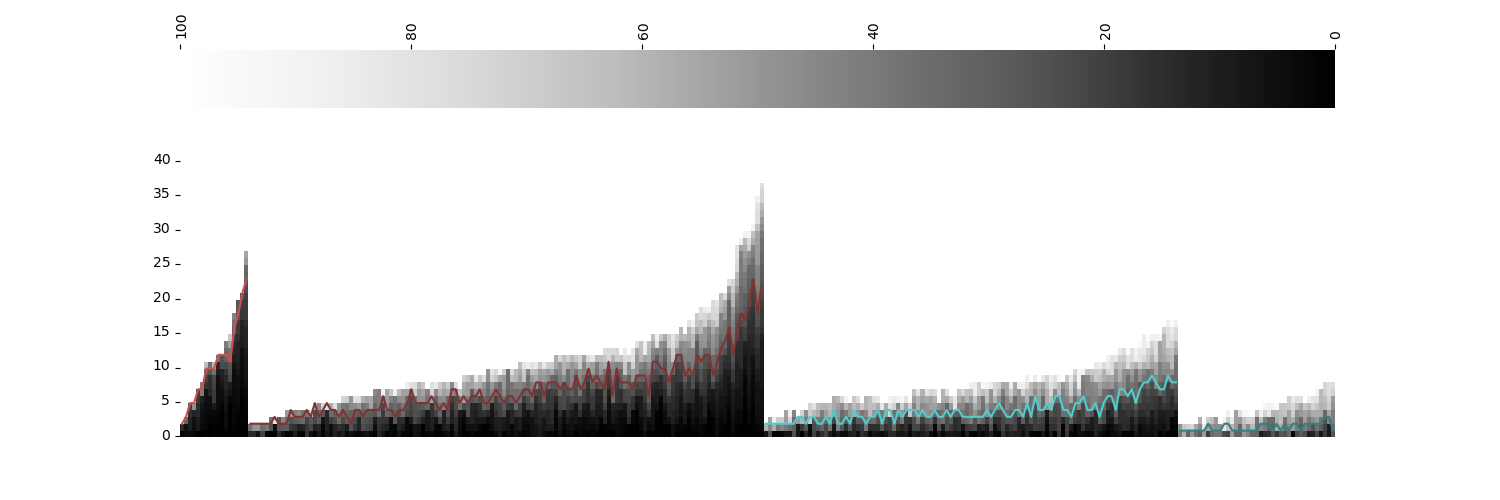

In [26]:
#rotated_image = image.rotate(0)
#resized_image = rotated_image.resize((4500, 1500))
display(image)

In [27]:
kmeans_site_color_dict = {k:matplotlib.colors.to_hex(sample_colors[v]) for k, v in kmeans_cluster_dict_new.items()}
un_labs = list(set(kmeans_c_labs_new))
kmeans_membership = {un_lab:[k for k, v in kmeans_cluster_dict_new.items() if v == un_lab] for un_lab in un_labs}

### VISUALISATION OF THE K-MEANS CLUSTERS - II: MULTI DIMENSIONAL SCALING (MDS)

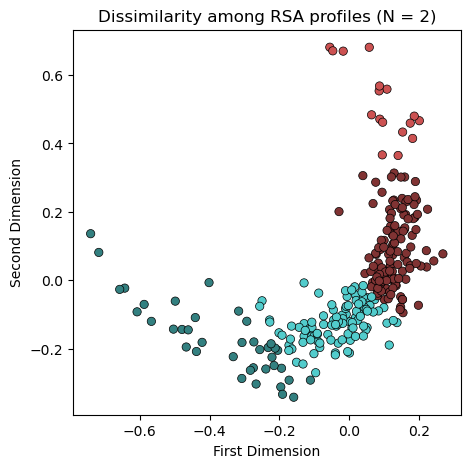

In [41]:
n = 2
cols = list(kmeans_site_color_dict.values())
mds_model = sklearn.manifold.MDS(n_components = n, random_state = 123,
    dissimilarity = 'precomputed', normalized_stress = False)
mds_fit = mds_model.fit(UD_df_subset)  
mds_coords = mds_model.fit_transform(UD_df_subset)

plt.figure(figsize=(5, 5), dpi= 100)
plt.scatter(
        mds_coords[:,0],mds_coords[:,1],
        color = cols, edgecolors = "k", 
        linewidth = 0.5, marker = "o"
        )
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('Dissimilarity among RSA profiles (N = {})'.format(n))

#plt.savefig(os.path.join(main_dir, "figs", "rsa_distrs_kmeans_reordered_n.png".format(n)))

plt.show()

#### SAVE CLUSTER MEMBERSHIP TO FILE

In [29]:
rsa_cluster_membership = {v1: k for k, v in kmeans_membership.items() for v1 in v}

In [35]:
dump_pickle(rsa_cluster_membership, os.path.join(results_dir, "rsa_cluster_membership.pkl"))

### EXPLORING LIGAND BINDING SITE HIERARCHICAL CLUSTERING

#### SINGLE LINKAGE CLUSTERING

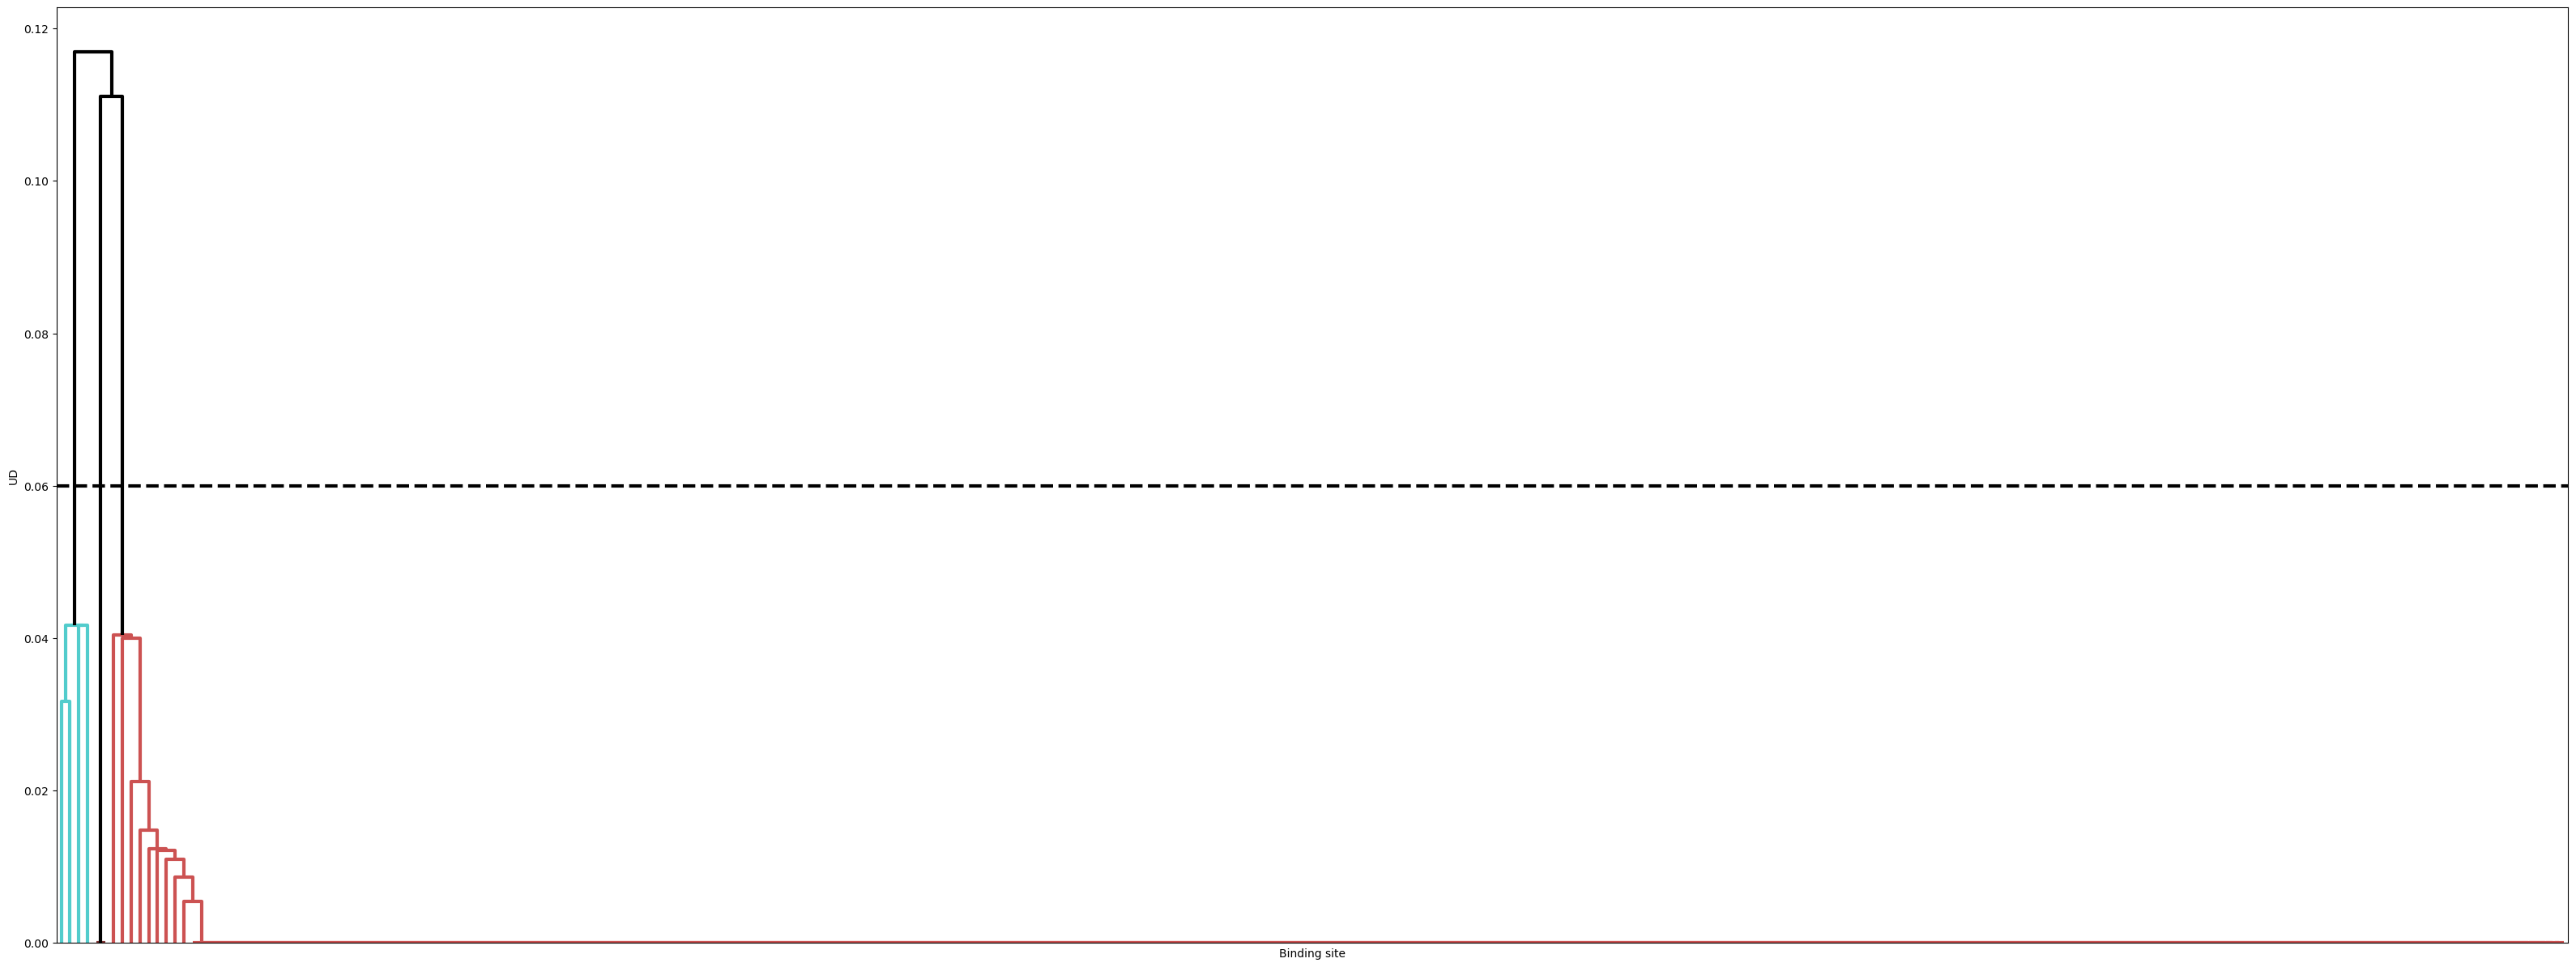

In [537]:
met = "single"
t = 0.06
rsa_t = 33.33

site_cluster_dict, cluster_ids, n_clusters = plot_color_dd(UD_df_subset, met, t, sample_colors) #os.path.join(main_dir, "figs", "rsa_distrs_tree_{}_{}.png".format(met, t))

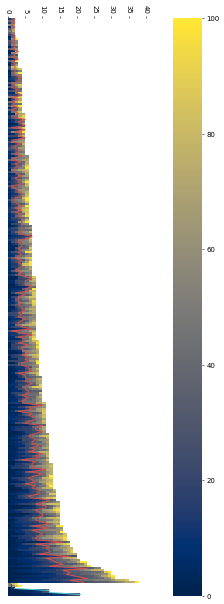

In [538]:
nks = [cluster_ids.count(i) for i in range(n_clusters)]

plot_clusters(
    rsas_profs_filt_hmap_subset, rsas_profs_filt_lens_subset, site_cluster_dict, nks, n_clusters, rsa_t = 25,
    fsize = (5, 15), dpi = 50, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)

#### COMPLETE LINKAGE CLUSTERING

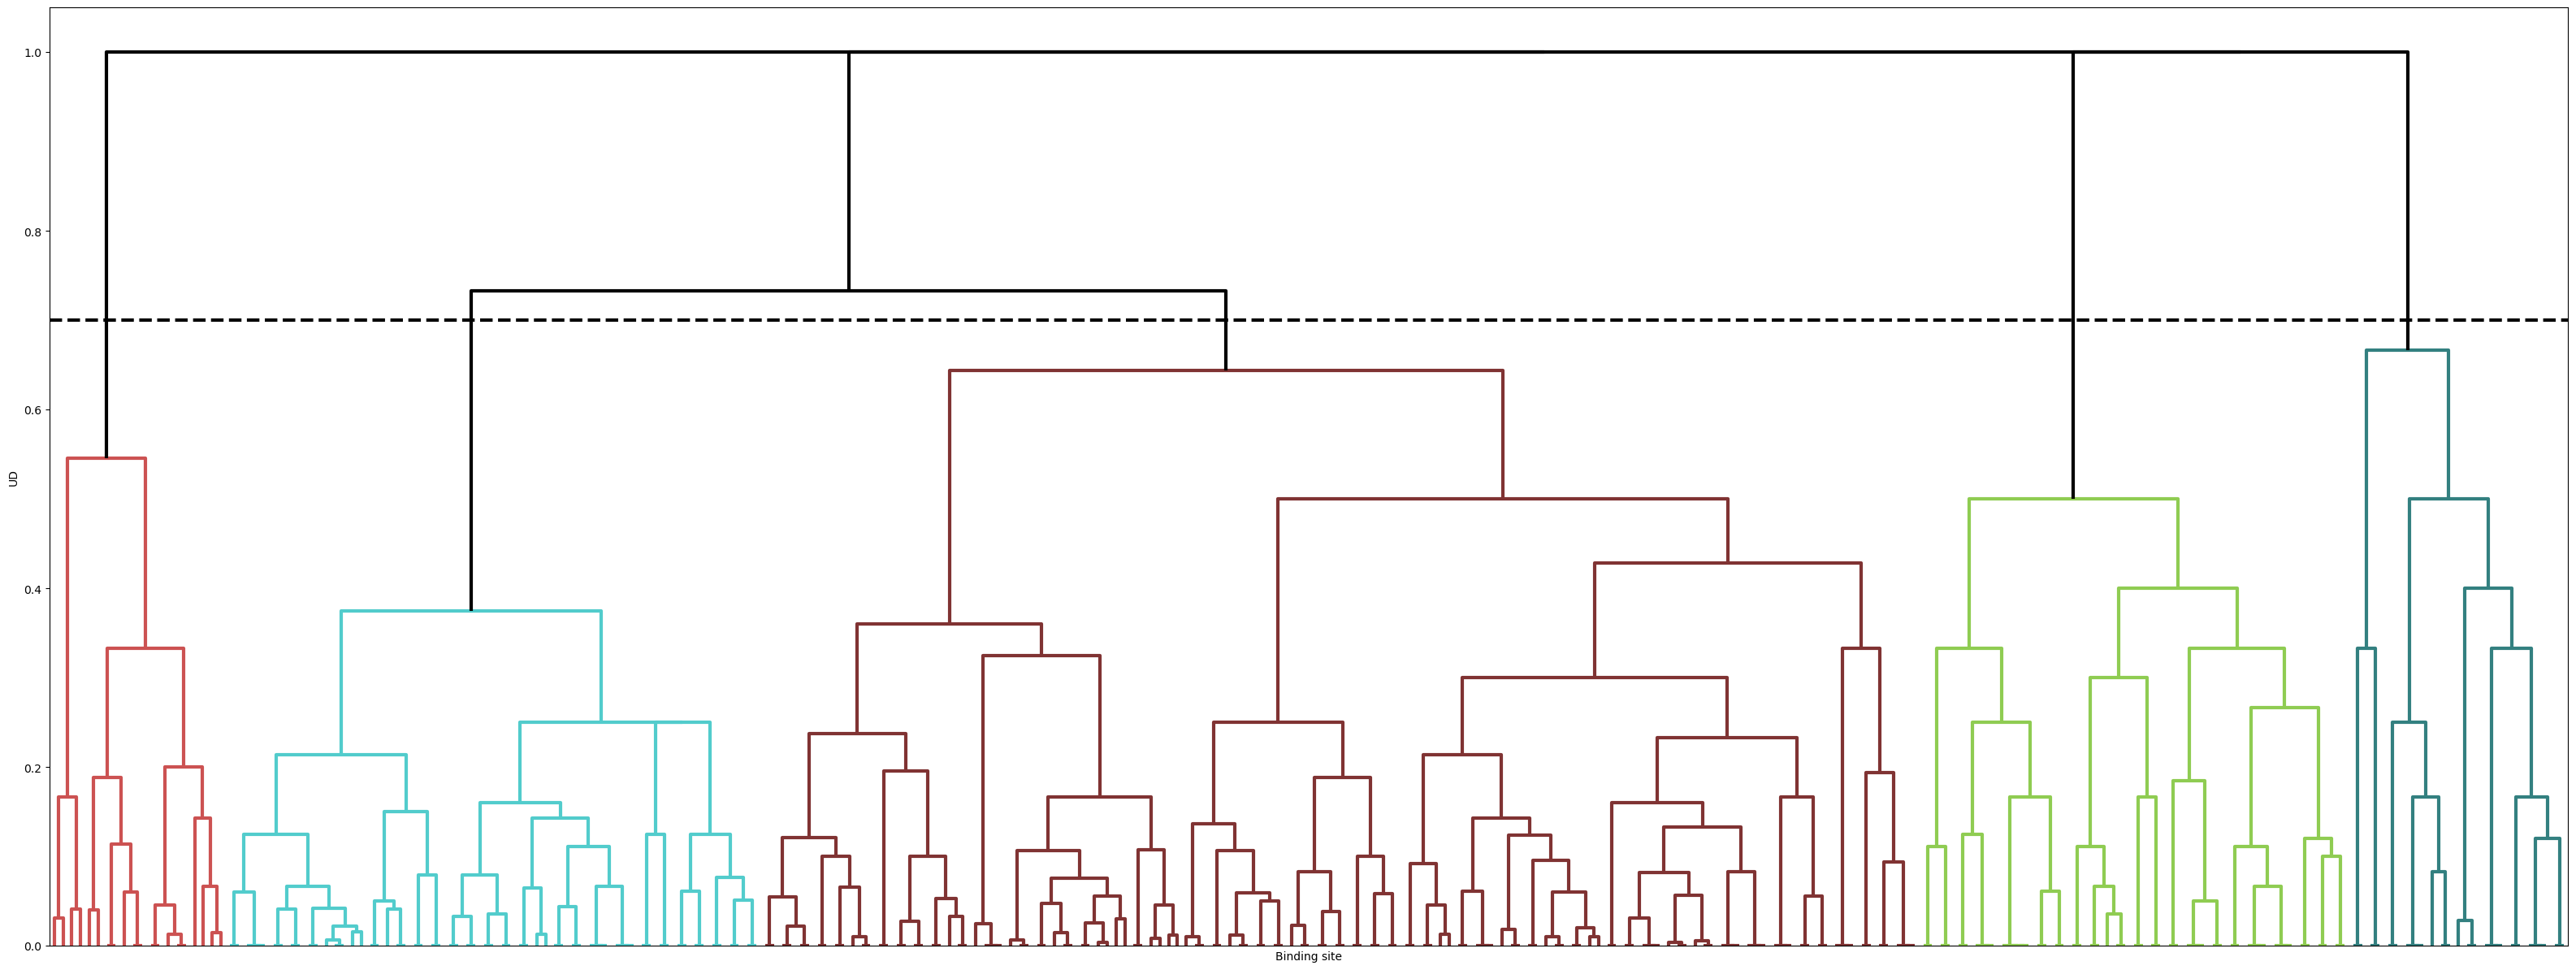

In [540]:
met = "complete"
t = 0.7
rsa_t = 33.33

site_cluster_dict, cluster_ids, n_clusters = plot_color_dd(UD_df_subset, met, t, sample_colors) #os.path.join(main_dir, "figs", "rsa_distrs_tree_{}_{}.png".format(met, t))

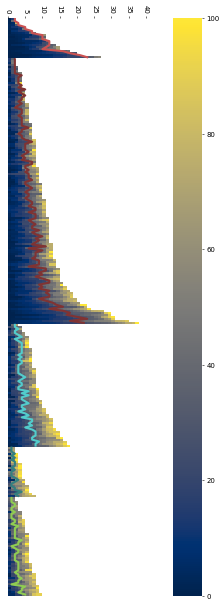

In [541]:
nks = [cluster_ids.count(i) for i in range(n_clusters)]

plot_clusters(
    rsas_profs_filt_hmap_subset, rsas_profs_filt_lens_subset, site_cluster_dict, nks, n_clusters, rsa_t = 25,
    fsize = (5, 15), dpi = 50, cmap = "cividis", out = None, show = True, rsa_t_lw = 3
)

#### UPGMA (AVERAGE)  CLUSTERING

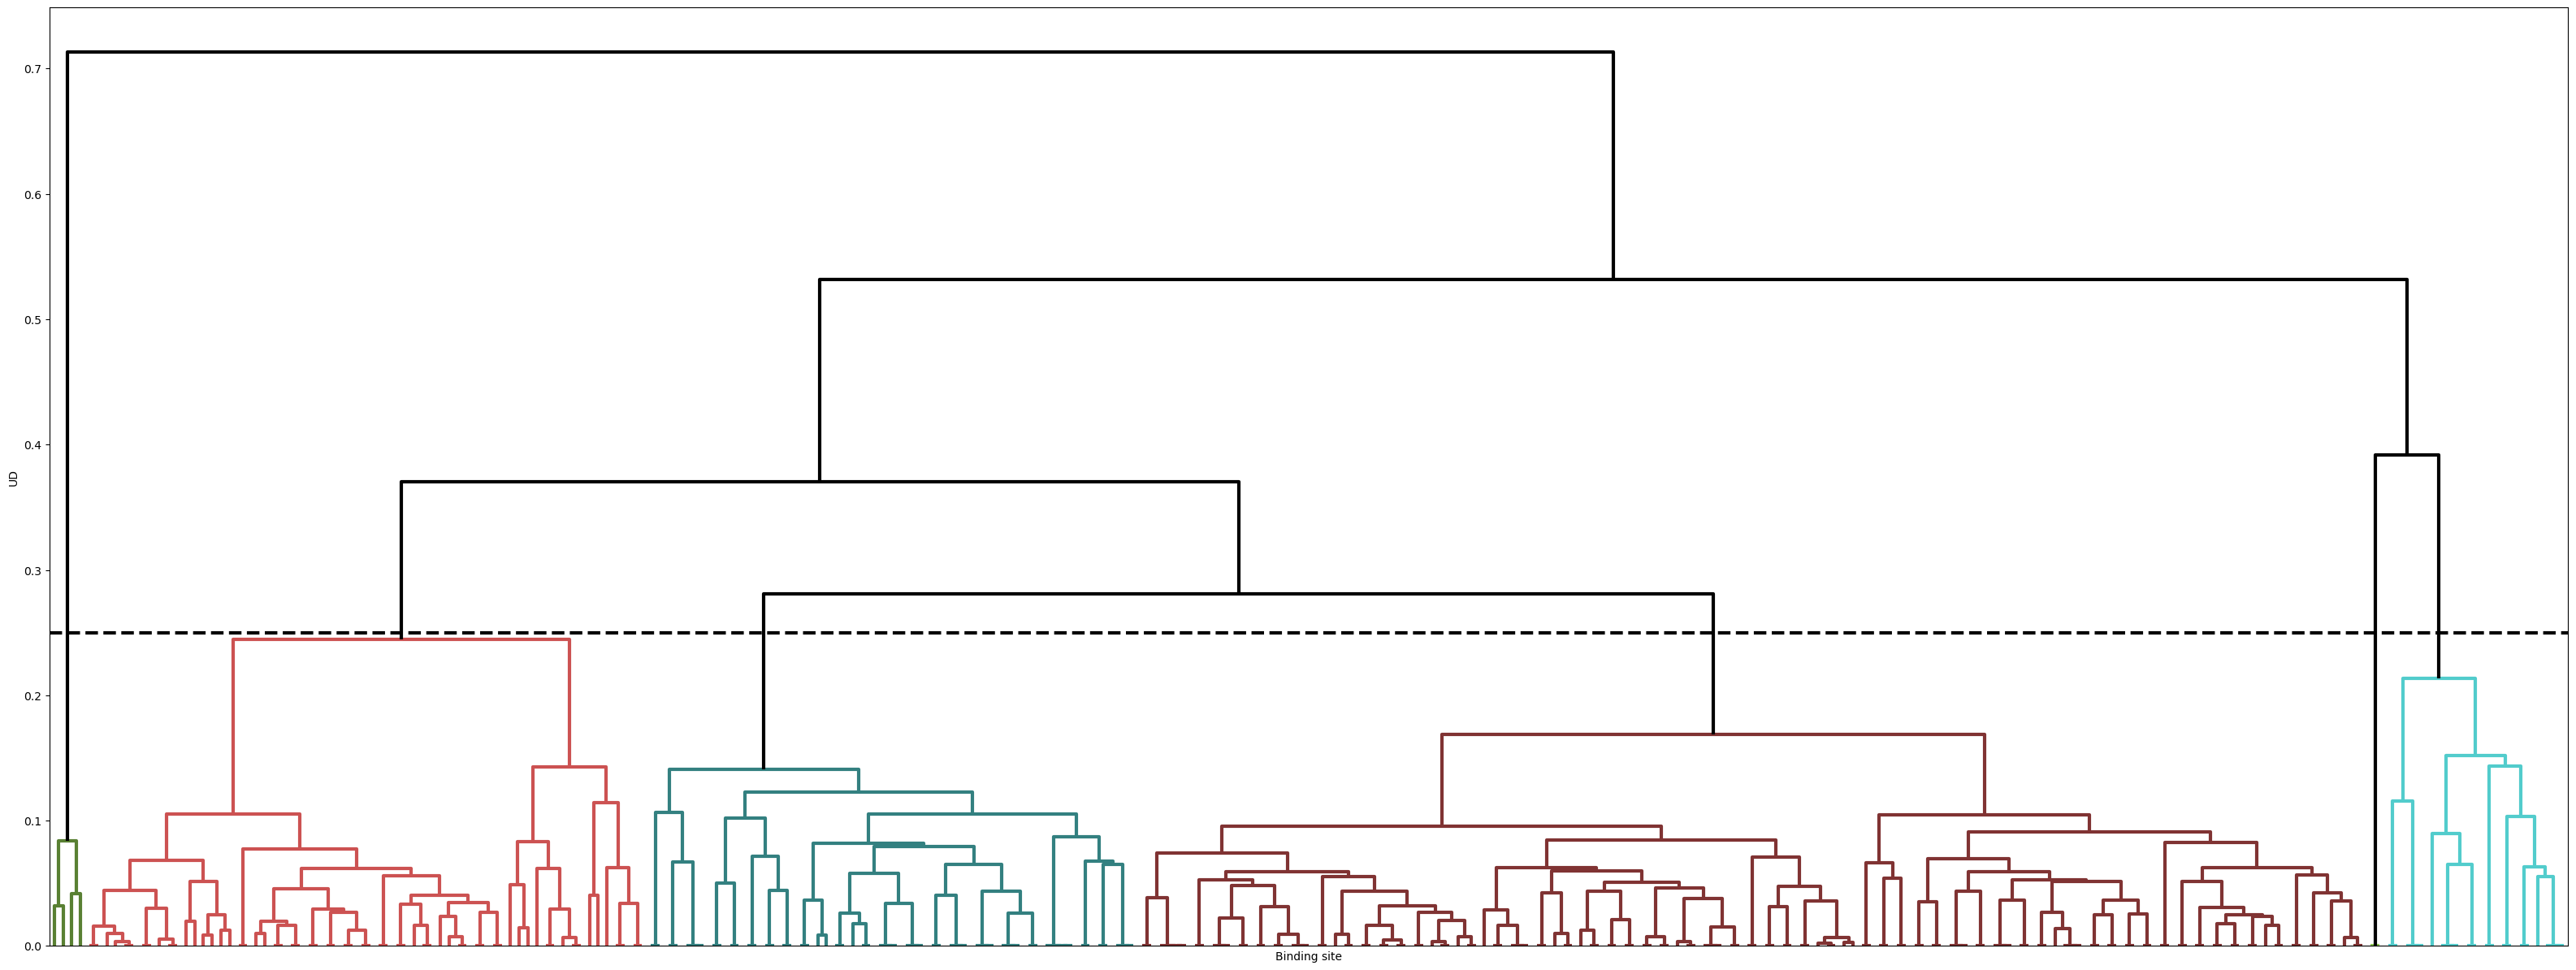

In [544]:
met = "average"
t = 0.25
rsa_t = 33.33

site_cluster_dict, cluster_ids, n_clusters = plot_color_dd(UD_df_subset, met, t, sample_colors) #os.path.join(main_dir, "figs", "rsa_distrs_tree_{}_{}.png".format(met, t))

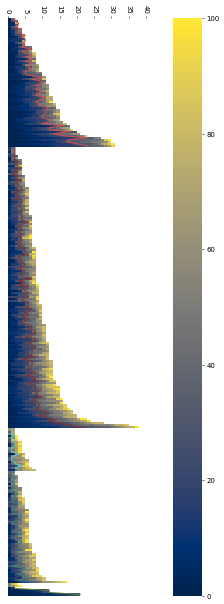

In [552]:
nks = [cluster_ids.count(i) for i in range(n_clusters)]

plot_clusters(
    rsas_profs_filt_hmap_subset, rsas_profs_filt_lens_subset, site_cluster_dict, nks, n_clusters, rsa_t = 25,
    fsize = (5, 15), dpi = 50, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)

#### WPGMA (WEIGHTED) LINKAGE CLUSTERING

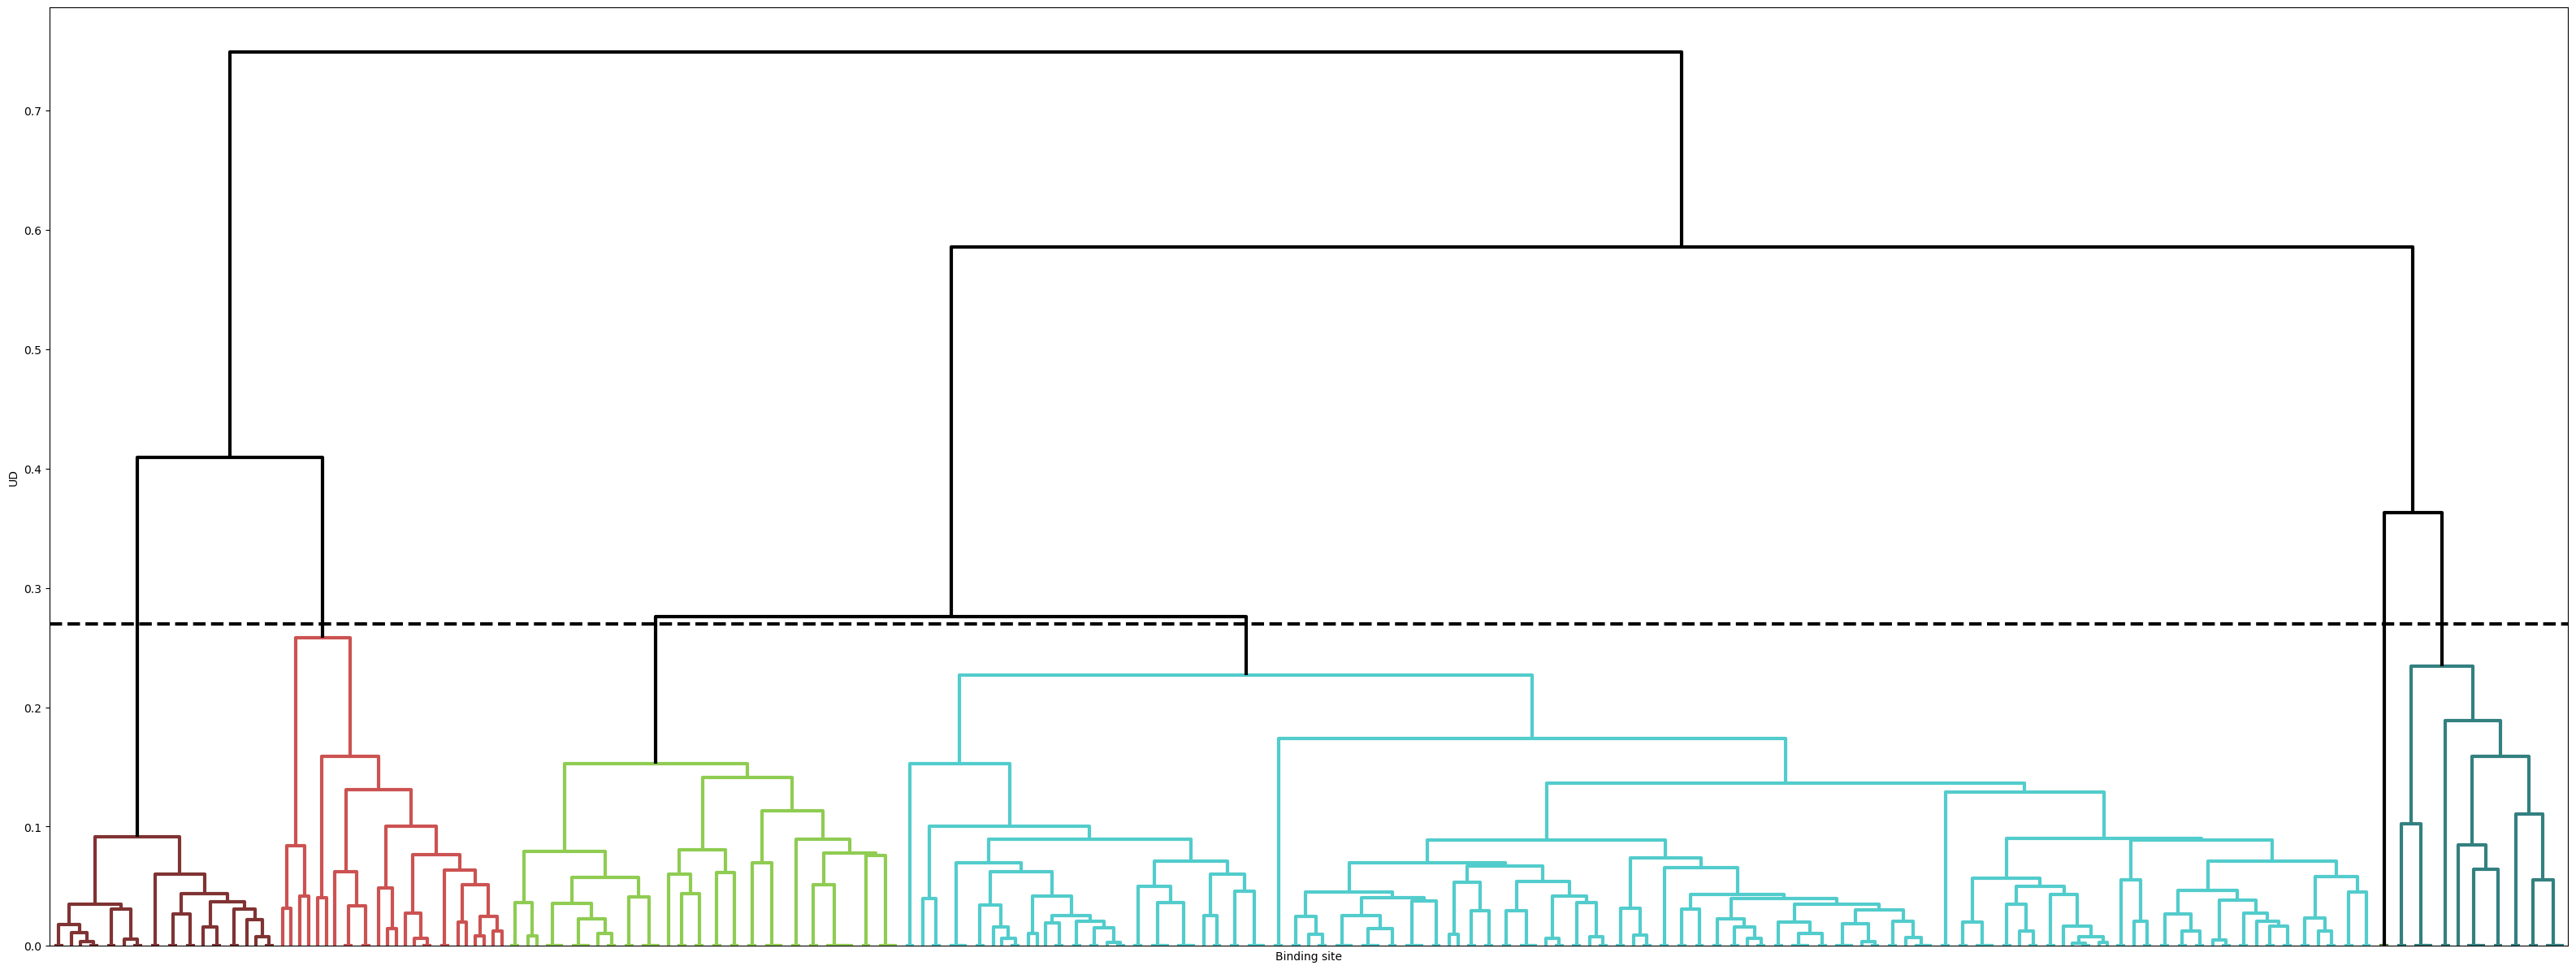

In [554]:
met = "weighted"
t = 0.27
rsa_t = 33.33

site_cluster_dict, cluster_ids, n_clusters = plot_color_dd(UD_df_subset, met, t, sample_colors) #os.path.join(main_dir, "figs", "rsa_distrs_tree_{}_{}.png".format(met, t))

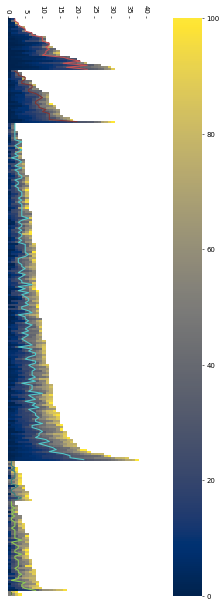

In [558]:
nks = [cluster_ids.count(i) for i in range(n_clusters)]

plot_clusters(
    rsas_profs_filt_hmap_subset, rsas_profs_filt_lens_subset, site_cluster_dict, nks, n_clusters, rsa_t = 25,
    fsize = (5, 15), dpi = 50, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)

#### UPGMC (CENTROID) LINKAGE CLUSTERING

##### WEIRD TREE REVERSALS WITH UPGMC MEANS THE TREE IS NOT PROPERLY CUT

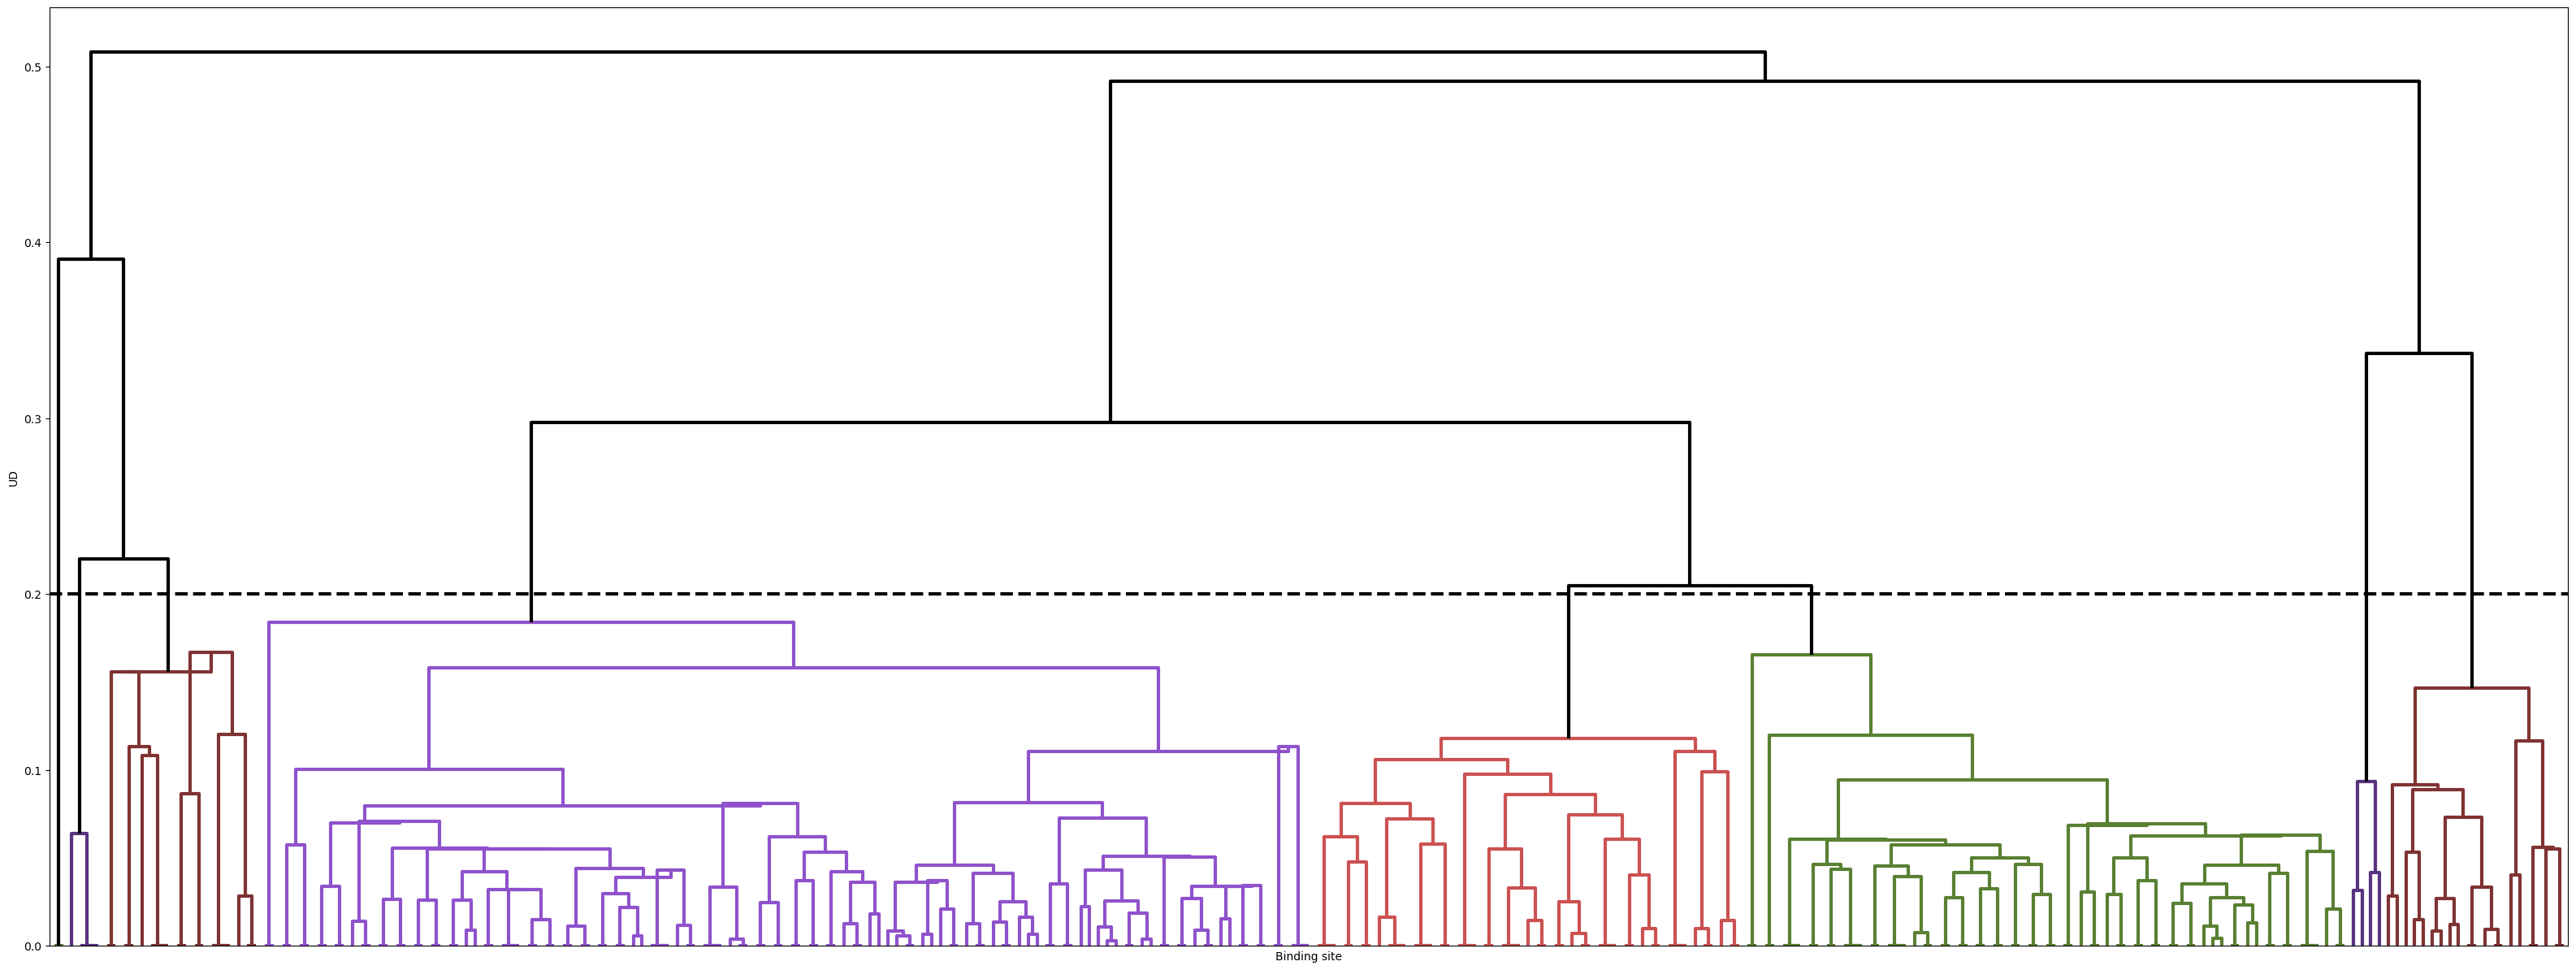

In [577]:
met = "centroid"
t = 0.2
rsa_t = 33.33

site_cluster_dict, cluster_ids, n_clusters = plot_color_dd(UD_df_subset, met, t, sample_colors) #os.path.join(main_dir, "figs", "rsa_distrs_tree_{}_{}.png".format(met, t))

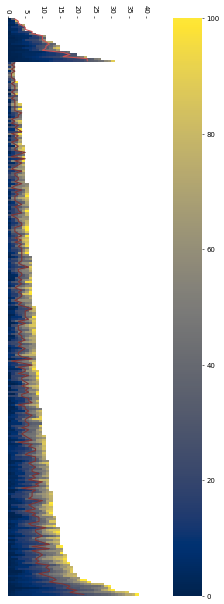

In [579]:
nks = [cluster_ids.count(i) for i in range(n_clusters)]

plot_clusters(
    rsas_profs_filt_hmap_subset, rsas_profs_filt_lens_subset, site_cluster_dict, nks, n_clusters, rsa_t = 25,
    fsize = (5, 15), dpi = 50, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)

#### WPGMC (MEDIAN) LINKAGE CLUSTERING

##### WEIRD TREE REVERSALS WITH UPGMC MEANS THE TREE IS NOT PROPERLY CUT

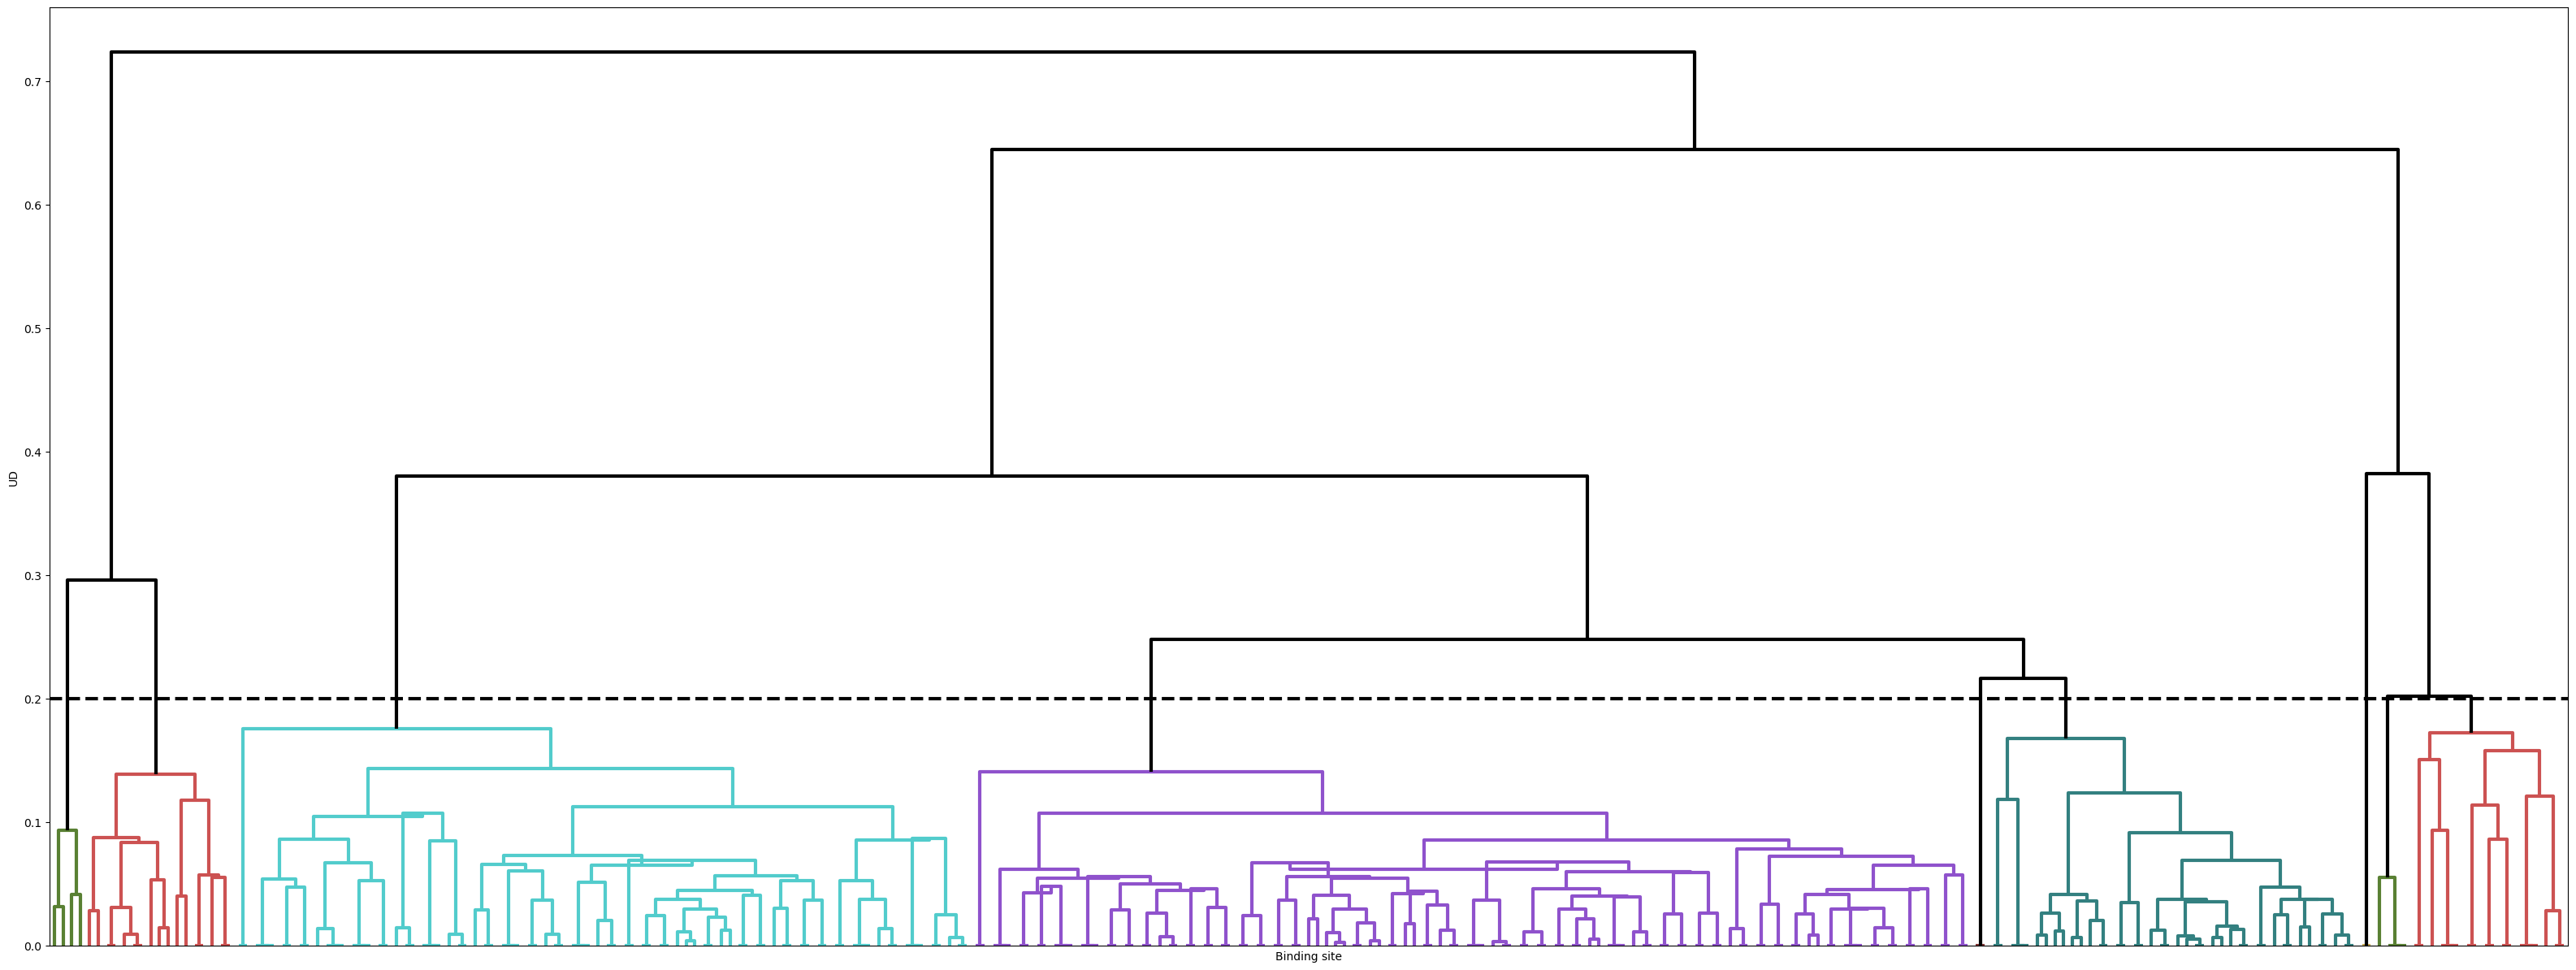

In [586]:
met = "median"
t = 0.2
rsa_t = 33.33

site_cluster_dict, cluster_ids, n_clusters = plot_color_dd(UD_df_subset, met, t, sample_colors) #os.path.join(main_dir, "figs", "rsa_distrs_tree_{}_{}.png".format(met, t))

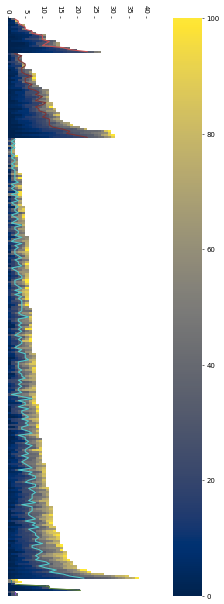

In [587]:
nks = [cluster_ids.count(i) for i in range(n_clusters)]

plot_clusters(
    rsas_profs_filt_hmap_subset, rsas_profs_filt_lens_subset, site_cluster_dict, nks, n_clusters, rsa_t = 25,
    fsize = (5, 15), dpi = 50, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)

#### WARD LINKAGE CLUSTEIRNG

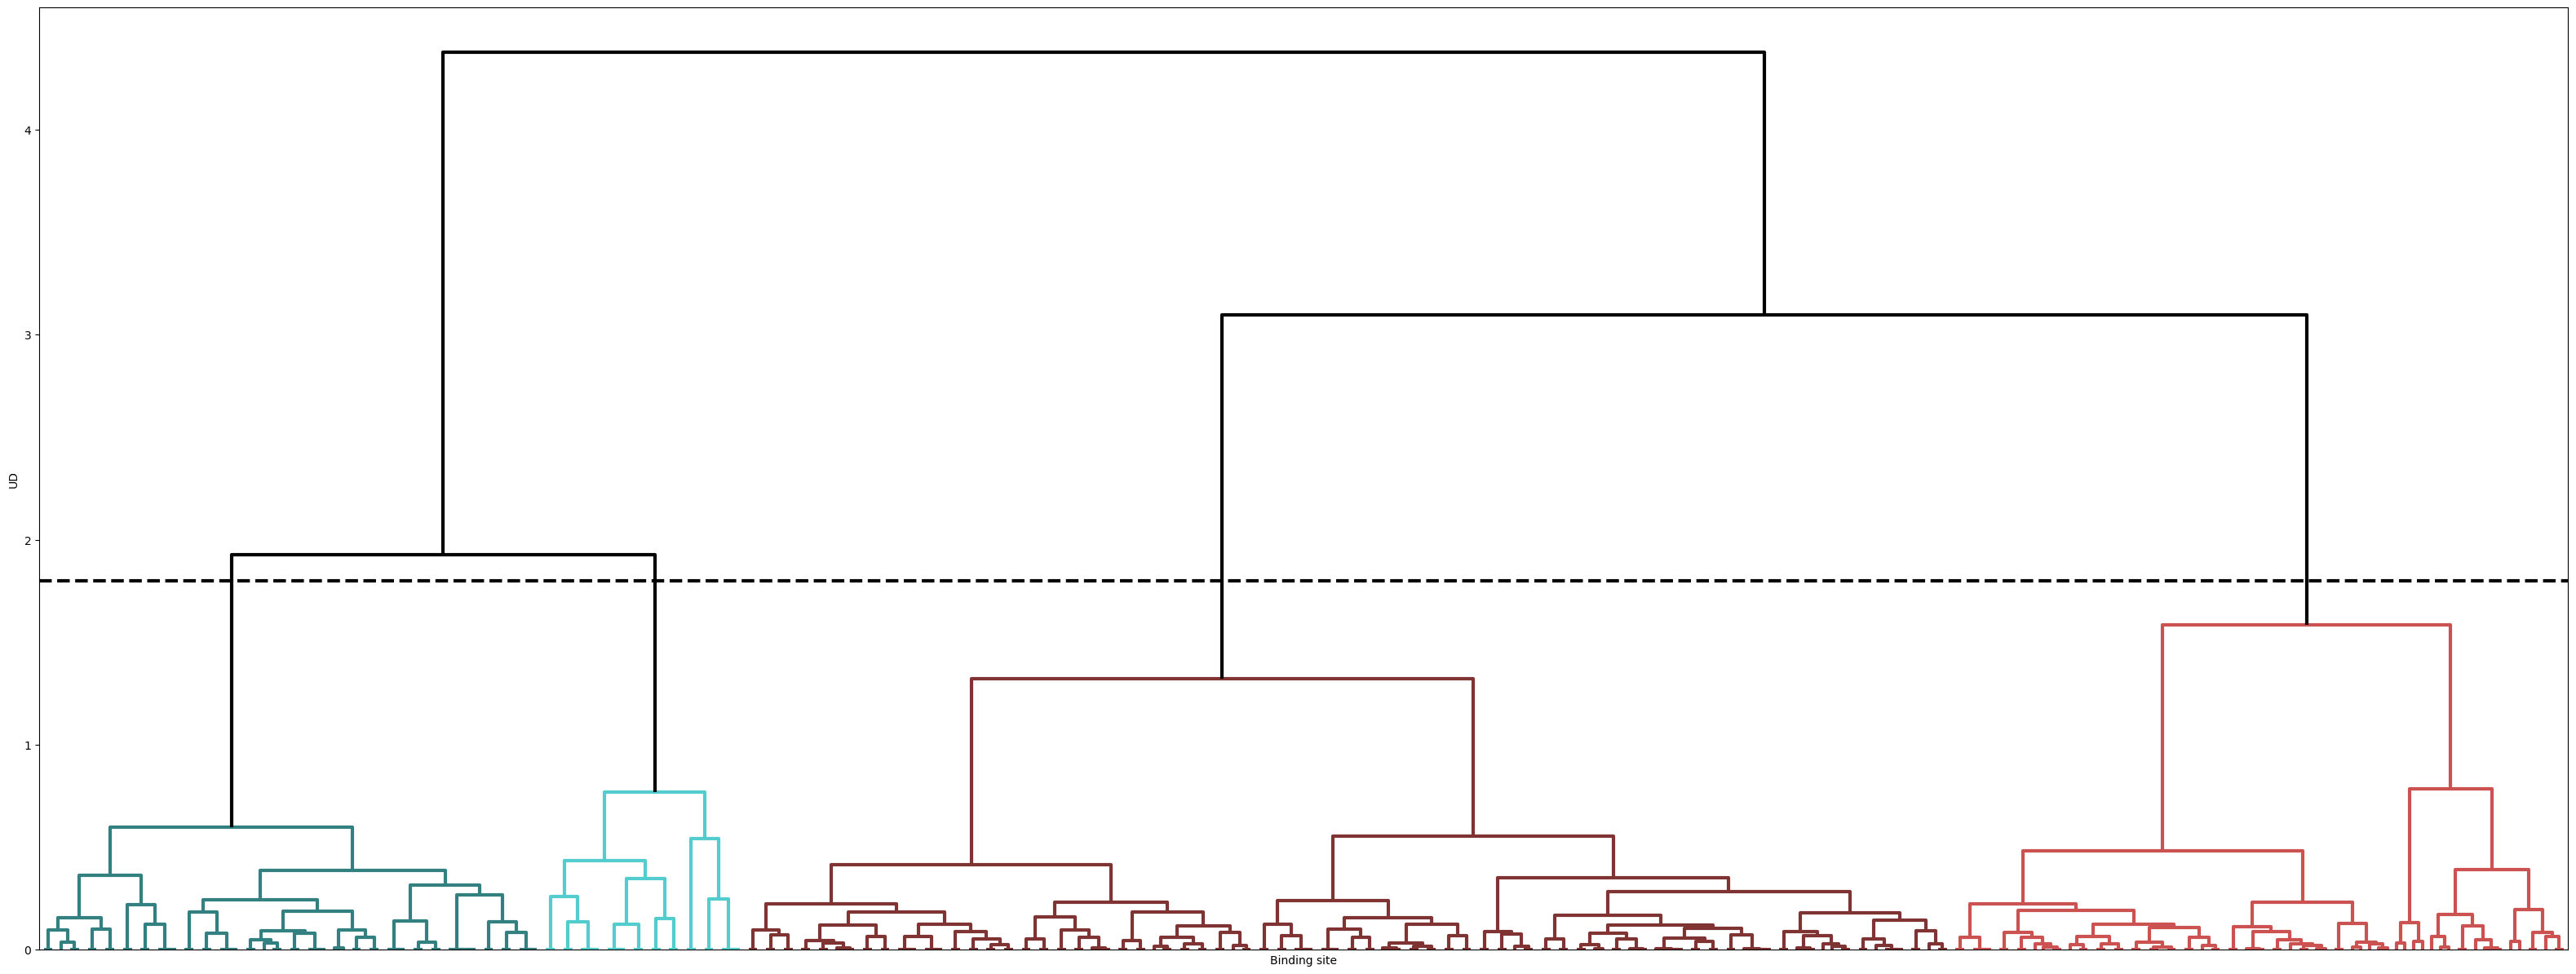

In [589]:
met = "ward"
t = 1.8
rsa_t = 33.33

site_cluster_dict, cluster_ids, n_clusters = plot_color_dd(UD_df_subset, met, t, sample_colors) #os.path.join(main_dir, "figs", "rsa_distrs_tree_{}_{}.png".format(met, t))

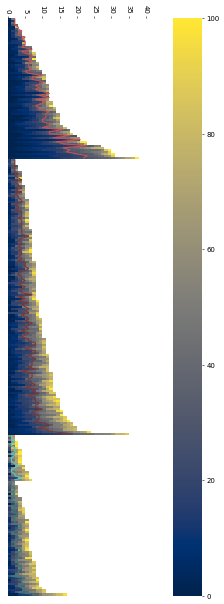

In [ ]:
nks = [cluster_ids.count(i) for i in range(n_clusters)]

plot_clusters(
    rsas_profs_filt_hmap_subset, rsas_profs_filt_lens_subset, site_cluster_dict, nks, n_clusters, rsa_t = 25,
    fsize = (5, 15), dpi = 50, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)